In [55]:
# Import necessary modules and functions

import pandas as pd # get information from files
import seaborn as sns # statistically summarizing information (for plots?)
import numpy as np # for large, multi-dimensional arrays and mathematical functions
import random

import matplotlib.pyplot as plt # a plotting library; (pyplot from python)
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats # scipy is a library for scientific computing; it imports statistical computation

# sklearn is a machine learning library:
from sklearn.preprocessing import StandardScaler # StandardScaler calculates z values
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import statistics
from datetime import date, datetime
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
data_train = pd.read_csv('KS_train_data.csv', delimiter = ',') # gets training dataset
data_test = pd.read_csv('KS_test_data.csv', delimiter = ',') # gets training dataset

    The kickstarter website is basically a platform where people can scroll and find businesses
    that need some support to start. As a simple user, you can choose to donate money: 1 USD or more;
    I believe most people donate 1 USD. If business reaches its goal until the pre-set deadline,
    it will be funded. If not, no user will loose his/her dollar.
    
    Each project has the following attributes that describe it (the ones with a star are also in the test set)
    (the ! symbol is the final training set):

    !*project_id = unique identifier of project
    backers_count = how many people + institutions financially support the project
    *blurb = short description of project
    !*category = theme of project; can be art, music, publishing, crafts, ...
    !*subcategory = subfield of category
    *country = country where business shall take place
    *name = name of business
    !*staff_pick = TRUE if someone from the Kickstarter.com staff likes your project (doesn't rlly help with anything)
    !*location = city in which the business is located
    !funded = TRUE or FALSE 
    *project_url = website of business
    *reward_url = website where you can donate money for this business
    
    pledged = how many people donated
    usd_pledged = how much usd was donated (usually the same as pledged, bcz most people donate 1 usd)
    converted_pledged_amount = how much money was donated (sum is here converted)
    !*goal = the minimal sum they have to reach in order to be funded
    !*currency = the currency in which the money are represented
    !*fx_rate = currency exchange rate
    
    *created_at = time when project is put on website
    !*deadline = maximum time when project should be launched
    !*launched_at = when Kickstarters.com aprove it and it's the first day you cand start receiving money

In [3]:
################################################## CLEANING DATA ##############################################################

# There are quite a few instances that have an unknown country
# All of them use USD as currency. Therefore, we assume all these projects
# are from the US:

country_attribute = []
for i in range(len(data_train)):
    if(data_train.iloc[i].country != '?'):
        country_attribute.append(data_train.iloc[i].country)
    else:
        country_attribute.append('US')
        
data_train['country'] = country_attribute

Index(['project_id', 'backers_count', 'blurb', 'category',
       'converted_pledged_amount', 'country', 'created_at', 'currency',
       'deadline', 'fx_rate', 'goal', 'launched_at', 'name', 'pledged',
       'staff_pick', 'usd_pledged', 'location', 'funded', 'subcategory',
       'project_url', 'reward_url'],
      dtype='object')

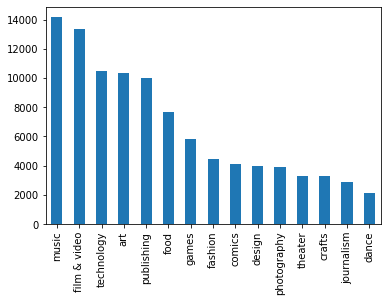

In [4]:
################################################# PICKING FEATURES ############################################################

# Analyzing the 'category' feature

data_train['category'].value_counts().plot(kind='bar')
data_train.columns

In [5]:
# Analyzing: The outputed vector shows the probability that, for each category, the project is picked to be funded

category_total_values = data_train['category'].value_counts()
categories = ['music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games',
             'fashion', 'comics', 'design', 'photography', 'theater', 'crafts', 'journalism', 'dance']
print(categories)

category_funded = [0 for x in range(14)]

for i in range(14):
    counter = 0
    for index, row in data_train.iterrows():
        if ((row.category == categories[i]) and (row.funded == True)):
            counter += 1
    category_funded[i] = (int)((counter * 100) / category_total_values[i])
      
print(category_funded)

['music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games', 'fashion', 'comics', 'design', 'photography', 'theater', 'crafts', 'journalism', 'dance']
[68, 61, 38, 55, 72, 36, 62, 44, 76, 72, 55, 75, 51, 30]


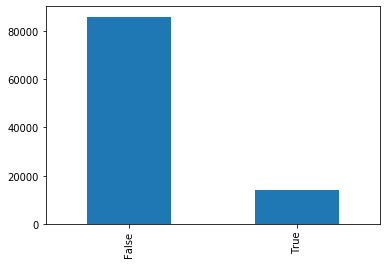

In [6]:
# Analyzing the 'staff_pick' feature

data_train['staff_pick'].value_counts().plot(kind='bar')

In [7]:
# 1. Creating the 'staff_pick_binary' feature
# This piece of code also shows the probability of a project to be picked when it has staff_picks or not

staff_pick_total_values = data_train['staff_pick'].value_counts()
print(staff_pick_total_values)

staff_pick_funded = [0 for x in range(2)]
staff_pick_binary = []

counter = 0
counter2 = 0
for index, row in data_train.iterrows():
    if(row.staff_pick == True):
        staff_pick_binary.append(1)
    if(row.staff_pick == False):
        staff_pick_binary.append(0)
    if ((row.staff_pick == False) and (row.funded == True)):
        counter += 1
    if ((row.staff_pick == True) and (row.funded == True)):
        counter2 += 1
        
staff_pick_funded[0] = (int)((counter * 100) / staff_pick_total_values[0])
staff_pick_funded[1] = (int)((counter2 * 100) / staff_pick_total_values[1])
      
print(staff_pick_funded)

data_train['staff_pick_binary'] = staff_pick_binary

[53, 89]


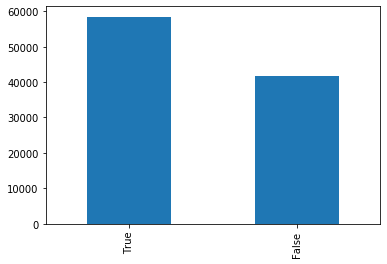

In [8]:
# 2. Creating the 'funded_binary' feature

data_train['funded'].value_counts().plot(kind='bar')

funded_binary = []

for i in range(len(data_train)):
    boolean = data_train.iloc[i].funded
    if boolean == True:
        funded_binary.append(1)
    elif boolean == False:
        funded_binary.append(0)
        
data_train['funded_binary'] = funded_binary

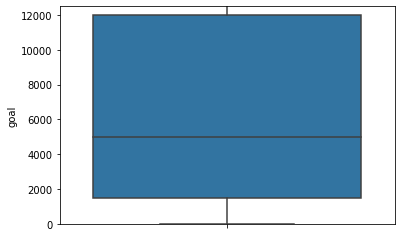

In [9]:
# 3. Creating the 'goal_per' feature
# print(data_train['goal'])

sns.boxplot(y=data_train.goal)
plt.ylim(0,12500)
      
data_train['goal_per'] = 0.00
for index, entry in enumerate(data_train['goal']):
    if entry > 10000:
        data_train.loc[index, 'goal_per'] = 0.25
    else:
        data_train.loc[index, 'goal_per'] = 1 - (entry / 10000)
        
# print(*data_train['goal_per'])

In [10]:
################################################ MAKE YOUR OWN ATTRIBUTES ####################################################

# 4. Creating the 'days_until_deadline' feature
# Calculates how many days a project has from launching to deadline

time_until_deadline = [0 for x in range(92)]

days_until_deadline = []

for i in range(len(data_train)):
    aux = (int)((data_train.iloc[i].deadline - data_train.iloc[i].launched_at)/60/60/24)
    days_until_deadline.append(aux)
    
data_train['days_until_deadline'] = days_until_deadline

0        0.511628
1        0.069767
2        0.150000
3        0.511628
4        0.302326
5        0.186047
6        0.744186
7        0.255814
8        0.150000
9        0.302326
10       0.558140
11       0.511628
12       0.418605
13       0.255814
14       0.302326
15       0.069767
16       0.302326
17       0.976744
18       0.674419
19       0.325581
20       0.325581
21       0.395349
22       0.069767
23       0.279070
24       0.046512
25       0.150000
26       0.348837
27       0.534884
28       0.209302
29       0.325581
           ...   
99970    0.302326
99971    0.302326
99972    0.023256
99973    0.906977
99974    0.302326
99975    0.302326
99976    0.302326
99977    0.069767
99978    0.348837
99979    0.348837
99980    0.302326
99981    0.302326
99982    0.348837
99983    0.325581
99984    0.372093
99985    0.150000
99986    0.511628
99987    0.150000
99988    0.279070
99989    0.302326
99990    0.302326
99991    0.302326
99992    0.348837
99993    0.150000
99994    0

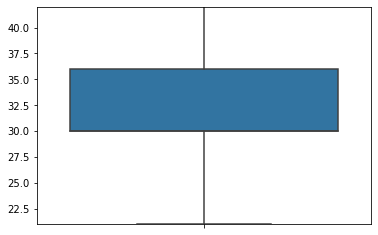

In [12]:
# ??????????????one last chance


sns.boxplot(y=days_until_deadline)
# print(days_until_deadline)
plt.ylim(21,42)

# outliers_low = 0
# outliers_low_funded = 0
# outliers_up = 0
# outliers_up_funded = 0
# outliers_m = 0
# outliers_m_funded = 0
# for index, entry in enumerate(data_train['funded_binary']):
#     if days_until_deadline[index] <21:
#         outliers_low += 1
#         if entry == 1:
#             outliers_low_funded += 1
#     if days_until_deadline[index] > 42:
#         outliers_up += 1
#         if entry == 1:
#             outliers_up_funded += 1
#     if days_until_deadline[index] >= 21 and days_until_deadline[index] <= 42:
#         outliers_m += 1
#         if entry == 1:
#             outliers_m_funded += 1
            
            
# print(statistics.mean(days_until_deadline))           
# print("Low outliers number:", outliers_low)
# print("Low outliers but funded number:", outliers_low_funded)
# print("Up outliers number:", outliers_up)
# print("Up outliers but funded number:", outliers_up_funded)
# print("Mijloc outliers number:", outliers_m)
# print("Mijloc outliers but funded number:", outliers_m_funded)
# sns.distplot(days_until_deadline)


data_train['time_until_deadline'] = 0.000

for index, entry in enumerate(data_train['time_until_deadline']):
    if days_until_deadline[index] > 43:
        data_train.loc[index, 'time_until_deadline'] = 0.15
    else:
        data_train.loc[index, 'time_until_deadline'] = 1 - (days_until_deadline[index] / 43)
    
print(data_train['time_until_deadline'])

# count1 = 0
# count2 = 0
# for index, entry in enumerate(data_train['funded']):
#     if money_each_day[index] > 400:
#         count1 += 1
#         if(entry == "1"):
#             count2 += 1
        
# print(count1)
# print(count2)


In [15]:
# 5. Creating the 'money_per_day' feature

money_each_day = []

for i in range(len(data_train)):
    aux = (int)((data_train.iloc[i].deadline - data_train.iloc[i].launched_at)/60/60/24)
    money = (int)(data_train.iloc[i].goal / aux)
    money_each_day.append(round(money))
    
data_train['money_per_day'] = money_each_day

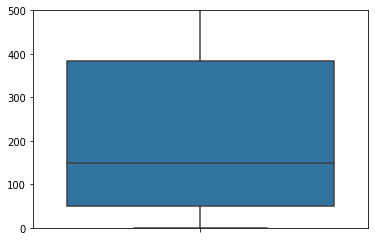

In [14]:
# 6. Creating the 'money_per_day_per' feature; it is a prediction
# The value is closer to 1 if it is likely to be funded
# It is computed by closely looking and the money_per_day attribute

sns.boxplot(y=money_each_day)
plt.ylim(0, 500)

data_train['money_per_day_per'] = 0.00
for index, entry in enumerate(money_each_day):
    if entry > 600:
        data_train.loc[index, 'money_per_day_per'] = 0.1
    elif entry > 400:
        data_train.loc[index, 'money_per_day_per'] = 0.2
    else:
        data_train.loc[index, 'money_per_day_per'] = 1 - (money_each_day[index] / 400) + 0.2

In [16]:
# 7. Creating the 'blurb_length' feature
# blurb_length - cor with funded: #0.032002518832337956

data_train['blurb'].astype(str)
blurb_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].blurb != data_train.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_train.iloc[i].blurb))  
data_train['blurb_length'] = blurb_length

In [17]:
# 8. Creating the 'name_length' feature
#name_length - cor with funded: #0.12593483192454363

data_train['name_length'] = data_train['name']
name_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].name_length != data_train.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_train.iloc[i].name_length))   
data_train['name_length'] = name_length

In [18]:
# 9. Creating the 'period_lc', 'period_dl', 'money_pday' features

launched_at = []
created_at = []
deadline = []
for i in range(len(data_train)):
    launched_at.append(datetime.utcfromtimestamp(data_train.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_train.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_train.iloc[i].deadline).strftime('%Y-%m-%d'))

date_format = "%Y-%m-%d"
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_train)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_train.iloc[i].goal / dl.days)) 
data_train['period_lc'] = period_lc
data_train['period_dl'] = period_dl
data_train['money_pday'] = money_pday

In [19]:
# 10. Creating the 'competitors_qtr', 'competitors_month' features

def get_year(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.year
data_train['launched_year'] = data_train['launched_at'].apply(get_year)

def get_month(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.month
data_train['launched_month'] = data_train['launched_at'].apply(get_month)

def get_week(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.isocalendar()[1]
data_train['launched_week'] = data_train['launched_at'].apply(get_week)

def get_quarter(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    if (time_s.month > 0 and time_s.month < 4):
        return 1
    if (time_s.month > 3 and time_s.month < 7):
        return 2
    if (time_s.month > 6 and time_s.month < 10):
        return 3
    if (time_s.month > 9 and time_s.month < 13):
        return 4
    
data_train['launched_quarter'] = data_train['launched_at'].apply(get_quarter)

data_train['goal_cat_perc'] =  data_train.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))
data_train['duration_cat_perc'] =  data_train.groupby(['category'])['period_dl'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

data_train['competitors_qtr'] = data_train.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['funded'].transform('count')
data_train['competitors_month'] = data_train.groupby(['category','launched_year','launched_month','goal_cat_perc'])['funded'].transform('count')

In [20]:
# 11. Create the dummy variable for the 'category' feature

data_train = pd.get_dummies(data_train, columns = ['category'])

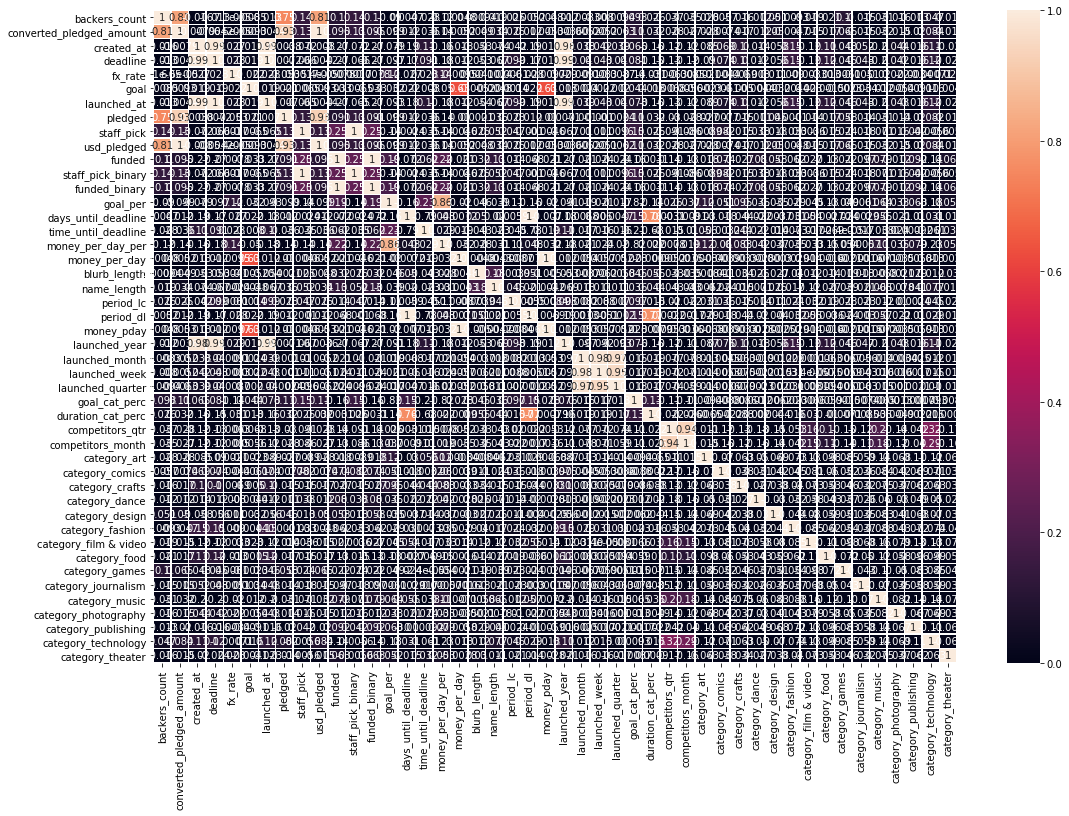

In [21]:
# Analyzing: Heatmaps are perfect for exploring the correlation of features in a dataset.

correlation_matrix = data_train.corr()

f,ax = plt.subplots(figsize=(18,12))
sns.heatmap(correlation_matrix, annot = True, linewidths = .5, ax = ax, vmin = 0, vmax = 1)

In [57]:
############################################# MULTIPLE LINEAR REGRESSION #######################################################

X = pd.DataFrame(np.c_[data_train['staff_pick_binary'], data_train['money_per_day_per'],
                       data_train['goal_per'], data_train['blurb_length'], data_train['name_length'], 
                       data_train['category_art'], data_train['category_comics'], data_train['category_crafts'],
                       data_train['category_dance'], data_train['category_design'], data_train['category_fashion'],
                       data_train['category_film & video'], data_train['category_food'], data_train['category_games'],
                       data_train['category_journalism'], data_train['category_music'], data_train['category_photography'],
                       data_train['category_publishing'], data_train['category_technology'], data_train['category_theater'],
                       data_train['competitors_qtr'], data_train['competitors_month']],  
                 columns = ['staff_pick_binary', 'money_per_day_per', 'goal_per', 'blurb_length', 'name_length', 
                        'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design',
                        'category_fashion', 'category_film & video', 'category_food', 'category_games',
                        'category_journalism', 'category_music', 'category_photography', 'category_publishing',
                        'category_technology', 'category_theater', 'competitors_qtr', 'competitors_month'])
Y = data_train['funded_binary']


X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.2, random_state = 9)

lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_Train, Y_Train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
# Making predictions:

pred = lin_reg_mod.predict(X_Test)
# print(*pred)

In [60]:
# Transfoming the predictions and calculating the model's performance:

for i in range(len(pred)):
    if(pred[i] >= 0.5):
        pred[i] = 1
    else:
        pred[i] = 0
        
accuracy = accuracy_score(Y_Test, pred)*100
print("Accuracy Score ->", accuracy)

# precision = TP / (TP + FP)
precision = precision_score(Y_Test, pred)*100
print("Precision Score ->", precision)

# recall = TP / (TP + FN)
recall = recall_score(Y_Test, pred)*100
print("Recall Score ->", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1-measure Score ->", f1_score)

Accuracy Score -> 71.17999999999999
Precision Score -> 72.48585439456808
Recall Score -> 81.94456289978677
F1-measure Score -> 76.92554043234587


In [42]:
############################################# PREDICT VALUES FOR SECOND SET####################################################

In [43]:
# 1. Creating the 'staff_pick_binary' feature

staff_pick_binary = []

for index, row in data_test.iterrows():
    if(row.staff_pick == True):
        staff_pick_binary.append(1)
    if(row.staff_pick == False):
        staff_pick_binary.append(0)

data_test['staff_pick_binary'] = staff_pick_binary

In [44]:
# 2. Creating the 'goal_per' feature
       
data_test['goal_per'] = 0.00

for index, entry in enumerate(data_test['goal']):
    if entry > 10000:
        data_test.loc[index, 'goal_per'] = 0.25
    else:
        data_test.loc[index, 'goal_per'] = 1 - (entry / 10000)

In [45]:
# 3. Creating the 'days_until_deadline' feature

days_until_deadline = []

for i in range(len(data_test)):
    aux = (int)((data_test.iloc[i].deadline - data_test.iloc[i].launched_at)/60/60/24)
    days_until_deadline.append(aux)
    
data_test['days_until_deadline'] = days_until_deadline

In [46]:
# 4. Creating the 'money_per_day' feature

money_each_day = []

for i in range(len(data_test)):
    aux = (int)((data_test.iloc[i].deadline - data_test.iloc[i].launched_at)/60/60/24)
    money = (int)(data_test.iloc[i].goal / aux)
    money_each_day.append(round(money))

data_test['money_per_day'] = money_each_day

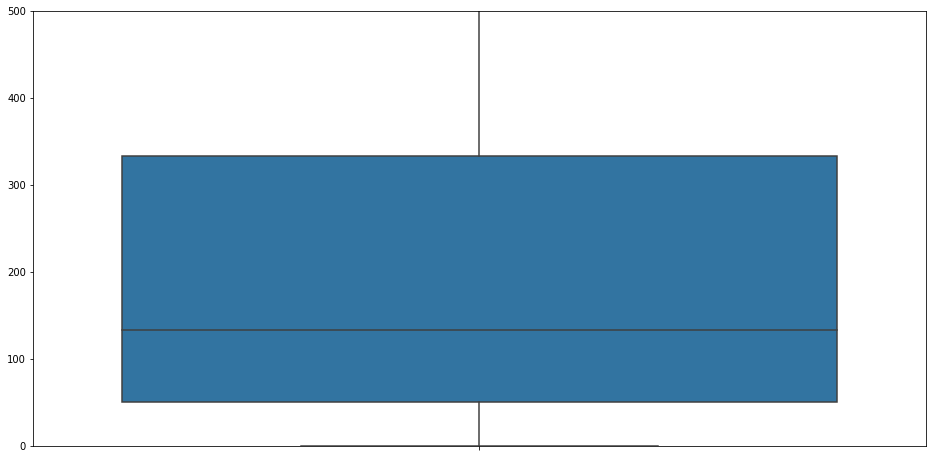

In [47]:
# 5. Creating the 'money_per_day_per' feature

sns.boxplot(y=money_each_day)
plt.ylim(0, 500)

data_test['money_per_day_per'] = 0.00
for index, entry in enumerate(money_each_day):
    if entry > 600:
        data_test.loc[index, 'money_per_day_per'] = 0.1
    elif entry > 400:
        data_test.loc[index, 'money_per_day_per'] = 0.2
    else:
        data_test.loc[index, 'money_per_day_per'] = 1 - (money_each_day[index] / 400) + 0.2 

In [48]:
# 6. Creating the 'blurb_length' feature
#blurb_length: cor with funded: #0.032002518832337956

data_test['blurb'].astype(str)
blurb_length = []
for i in range(len(data_test)):
    if data_test.iloc[i].blurb != data_test.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_test.iloc[i].blurb))  
data_test['blurb_length'] = blurb_length

In [49]:
# 7. Creating the 'name_length' feature
#name_length: #0.12593483192454363

data_test['name_length'] = data_test['name']
name_length = []
for i in range(len(data_test)):
    if data_test.iloc[i].name_length != data_test.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_test.iloc[i].name_length))   
data_test['name_length'] = name_length

In [50]:
# 8. Creating the 'period_lc', 'period_dl', 'money_pday' features

launched_at = []
created_at = []
deadline = []
for i in range(len(data_test)):
    launched_at.append(datetime.utcfromtimestamp(data_test.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_test.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_test.iloc[i].deadline).strftime('%Y-%m-%d'))

date_format = "%Y-%m-%d"
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_test)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_test.iloc[i].goal / dl.days)) 
data_test['period_lc'] = period_lc
data_test['period_dl'] = period_dl
data_test['money_pday'] = money_pday

In [51]:
data_test['launched_month'] = data_test['launched_at'].apply(get_month)
data_test['launched_week'] = data_test['launched_at'].apply(get_week)
data_test['launched_quarter'] = data_test['launched_at'].apply(get_quarter)
data_test['goal_cat_perc'] =  data_test.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))
data_test['duration_cat_perc'] =  data_test.groupby(['category'])['period_dl'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

In [52]:
data_test['launched_year'] = data_test['launched_at'].apply(get_year)
data_test['competitors_qtr'] = data_test.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['name'].transform('count')
data_test['competitors_month'] = data_test.groupby(['category','launched_year','launched_month','goal_cat_perc'])['name'].transform('count')

In [53]:
# 9. Creating the dummy variable for the 'category' feature

data_test = pd.get_dummies(data_test, columns = ['category'])

In [54]:
################################################ DATA TEST EVALUATION ##########################################################

In [61]:
X = pd.DataFrame(np.c_[data_train['staff_pick_binary'], data_train['money_per_day_per'], 
                       data_train['goal_per'], data_train['blurb_length'], data_train['name_length'], 
                       data_train['category_art'], data_train['category_comics'], data_train['category_crafts'],
                       data_train['category_dance'], data_train['category_design'], data_train['category_fashion'],
                       data_train['category_film & video'], data_train['category_food'], data_train['category_games'],
                       data_train['category_journalism'], data_train['category_music'], data_train['category_photography'],
                       data_train['category_publishing'], data_train['competitors_qtr'], data_train['competitors_month']],  
                 columns = ['staff_pick_binary', 'money_per_day_per', 'goal_per', 'blurb_length', 'name_length', 
                        'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design',
                        'category_fashion', 'category_film & video', 'category_food', 'category_games',
                        'category_journalism', 'category_music', 'category_photography', 'category_publishing',
                        'competitors_qtr', 'competitors_month'])
Y = data_train['funded_binary']

In [62]:
X_Test = pd.DataFrame(np.c_[data_test['staff_pick_binary'], data_test['money_per_day_per'], data_test['goal_per'], 
                       data_test['blurb_length'], data_test['name_length'], data_test['category_art'], 
                       data_test['category_comics'], data_test['category_crafts'], data_test['category_dance'], 
                       data_test['category_design'], data_test['category_fashion'], data_test['category_film & video'],
                       data_test['category_food'], data_test['category_games'], data_test['category_journalism'], 
                       data_test['category_music'], data_test['category_photography'], data_test['category_publishing'], 
                       data_test['competitors_qtr'], data_test['competitors_month']],  
                 columns = ['staff_pick_binary', 'money_per_day_per', 'goal_per', 'blurb_length', 'name_length', 
                        'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design',
                        'category_fashion', 'category_film & video', 'category_food', 'category_games',
                        'category_journalism', 'category_music', 'category_photography', 'category_publishing',
                        'competitors_qtr', 'competitors_month'])

In [65]:
# Making predictions:

lin_reg_mod.fit(X, Y)
pred = lin_reg_mod.predict(X_Test)

# print(*pred)

for i in range(len(pred)):
    if(pred[i] >= 0.5):
        pred[i] = 1
    else:
        pred[i] = 0
        
# print(*pred)

In [66]:
pred_results = pd.DataFrame(index = data_test.index)
pred_results['your_prediction'] = pred

In [145]:
import csv
label_file = "predictions.tsv"
with open(label_file, 'w') as write_tsv:
    write_tsv.write(pred_results.to_csv(sep='\t', index = True))

# Correctness


In [36]:
def calculate_confusion(pred, answers):
    TP = FP = FN = TN = 0
    
    answers_keys = answers.keys()
    results = [[0 for x in range(2)] for y in range(20000)]


    for x in range(len(answers)):
        index = answers_keys[x]
        results[x] = [pred[x], answers[index]]

    for x in range(len(results)):
        if (results[x][0] == 1):
            if (results[x][1] == 1):
                TP += 1
            else:
                FP += 1
        else:
            if (results[x][1] == 0):
                TN += 1
            else:
                FN += 1
    return [TP, FP, FN, TN]


def accuracy(tp, fp, fn, tn):
    correct = tp + tn
    total = tp + fp + fn + tn
    return correct / total

def precision(tp, fp, fn, tn):
    return tp / (tp + fp)

def recall(tp, fp, fn, tn):
    return tp / (tp + fn)

def f1_score(tp, fp, fn, tn):
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)
    return 2 * p * r / (p + r)

Accuracy: 0.60
Precision: 0.61
Recall: 0.91
F1 score: 0.73


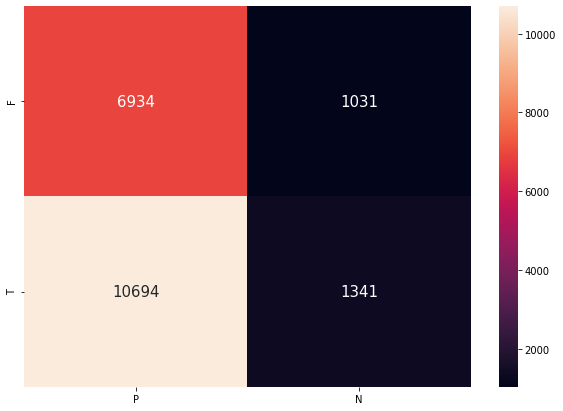

In [39]:
confusion_values = calculate_confusion(pred, Y_test)
TP = confusion_values[0]
FP = confusion_values[1]
FN = confusion_values[2]
TN = confusion_values[3]

values = [[FP, FN], [TP, TN]]
df_cm = pd.DataFrame(values, index = [i for i in "FT"],
                  columns = [i for i in "PN"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 15})

print("Accuracy: %.2f" % accuracy(TP,FP,FN,TN))
print("Precision: %.2f" % precision(TP,FP,FN,TN))
print("Recall: %.2f" % recall(TP,FP,FN,TN))
print("F1 score: %.2f" % f1_score(TP,FP,FN,TN))